# **Historia de Operaciones a Modelo IA *Basic Bot Supertrend Product***
# By: S&S Investments

## Creación del entorno (Importación Librerias)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from ydata_profiling import ProfileReport
import seaborn as sns
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

/home/santiago/Documentos/S&S_Investments/IA_Explore/EDA_SS_IA/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Crear Flujo de extracción de datos 

In [2]:
#Definición de funciones usadas en el Flujo

def get_pathfile_list(base_path: str)->list:
    ret_list = []
    for dirname, _, filenames in os.walk(base_path):
        for filename in filenames:
            ret_list.append(os.path.join(dirname, filename)) 
    return ret_list 


def load_pandas_dataframe(path:str)->pd.DataFrame:
    try:
        df = pd.read_csv(path,  sep=",")
        return df
    except FileNotFoundError:
        print(f"Error: The file '{path}' was not found.")
        return None
    except pd.errors.EmptyDataError:
        print(f"Error: The file '{path}' is empty.")
        return None
    except pd.errors.ParserError:
        print(f"Error: There was a problem parsing the file '{path}'.")
        return None
    except UnicodeDecodeError:
        print(f"Error: The file '{path}' has an encoding issue.")
        return None
    except ValueError as ve:
        print(f"ValueError: {ve}")
        return None
    except TypeError as te:
        print(f"TypeError: {te}")
        return None
    except IsADirectoryError:
        print(f"Error: '{path}' is a directory, not a file.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None


def load_merge_files(list_paths:list)->pd.DataFrame:
    if len(list_paths) > 0:

        if len(list_paths) == 1:
            temp_df = load_pandas_dataframe(list_paths[0])
            if temp_df is not None and not temp_df.empty:
                return temp_df
            else:
                return None
        else:
            for path in list_paths:
                list_dfs = []
                temp_df = load_pandas_dataframe(path)
                if temp_df is not None and not temp_df.empty:
                    list_dfs.append(temp_df)
            del temp_df #Deleate temporal registers

            if len(list_dfs) > 0:
                merged_df = pd.concat(list_dfs, axis=0, ignore_index=True)
                del list_dfs
                return merged_df #Return Merged Dataframe
            else:
                del list_dfs
                return None

def extraction_flux(general_dir_path:str):
    file_list = get_pathfile_list(general_dir_path)
    if len(file_list) > 0:
        df = load_merge_files(file_list)

        if len(file_list) > 1:
            if os.path.exists(general_dir_path + "/Merged_History.csv"):
                os.remove(general_dir_path + "/Merged_History.csv")
            df.to_csv(general_dir_path + "/Merged_History.csv")
        return df
    else:
        return None


## Crear columna de Simulación de aporte cuantitativo por orden 

In [5]:
def create_dataframe_resource_directory():
    df_history = extraction_flux("Resources")
    #Restar el precio de salida por el de cierre (Profit sin apalancamiento, ni comisión de bybit)
    df_history["Simulation_Profit"] = df_history["Exit-Price"] - df_history["Close"]
    df_history.loc[df_history['Polaridad'] == "Sell", 'Simulation_Profit'] *= -1
    #Ordenar dataframe por la fecha
    df_history_ordered = df_history.sort_values('Time')
    return df_history_ordered

def create_dataframe_one_file(path:str):
    df_history = load_pandas_dataframe(path)
    #Ordenar dataframe por la fecha
    df_history_ordered = df_history.sort_values('Time')
    return df_history_ordered

df_history_ordered = create_dataframe_one_file("Resources/history_SP3_DEMA800_30M_3Y.csv") #Usar historia de 3 años
df_history_ordered.head(5)

,Time,Symbol,Open,High,Low,Close,Volume,Supertrend,Polaridad,DEMA800,Half-Order,Profit,Stoploss-Reached,Exit-Price,ATR,ADX,P&L
0,2021-10-24 03:00:00-05:00,XRPUSDT,1.0848,1.0860,1.0831,1.0842,1473773.0,1.093251,Sell,1.130686,True,False,False,1.084200,0.003242,20.870454,0.0294
1214,2021-10-24 06:30:00-05:00,DOTUSDT,43.3150,43.3450,42.4850,42.5950,103502.6,44.030335,Sell,45.024116,False,False,True,44.030335,0.330754,15.977562,-1.4080
1215,2021-10-26 09:00:00-05:00,DOTUSDT,44.0950,44.1050,43.3050,43.6300,67713.6,44.732323,Sell,45.379222,False,False,True,44.732323,0.302189,14.459867,-0.8080
1,2021-10-26 09:00:00-05:00,XRPUSDT,1.1121,1.1123,1.0950,1.1008,10803134.0,1.124411,Sell,1.123274,False,False,True,1.124411,0.006311,23.326970,-0.2142
1216,2021-10-26 17:30:00-05:00,DOTUSDT,45.2050,45.2050,43.6450,44.3450,115117.2,46.551982,Sell,45.498452,True,True,False,42.470000,0.540539,25.676744,1.6680


## Analisis Exploratorio de Datos (EDA)

In [6]:
profile = ProfileReport(df_history_ordered, title="Simulation Profiling Report")

In [7]:
profile.to_file("Reports/EDA_Report.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 13.21it/s]


### Exploración Extra con Graficas

#### Grafica de Simulación-Profit acumulado por serie de tiempo 

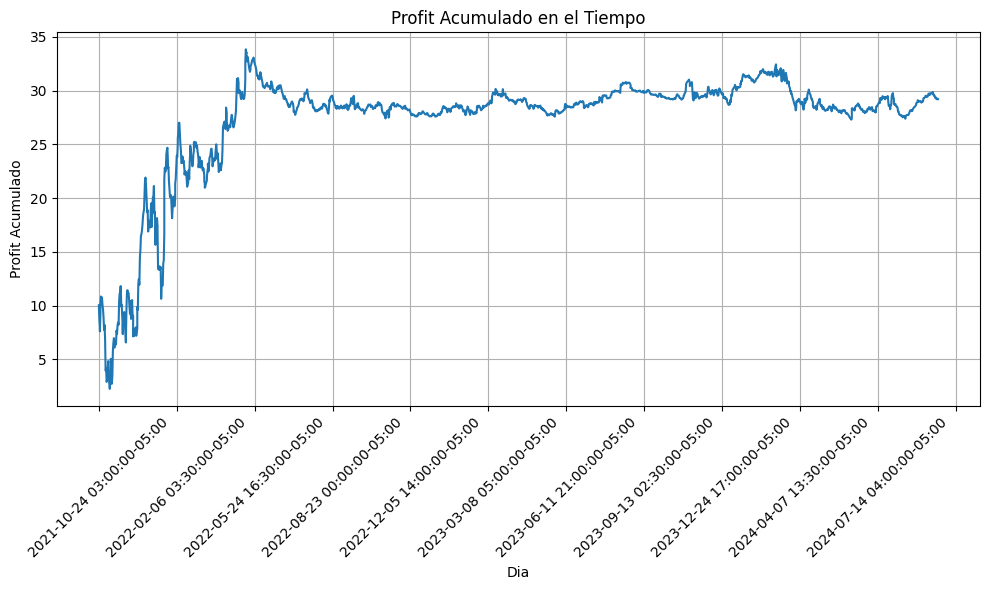

In [8]:
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

initial_profit = 10
new_serie_acumulada = []

for i in range(len(df_history_ordered)):
    initial_profit += df_history_ordered['P&L'].iloc[i]
    new_serie_acumulada.append(initial_profit)

#Crear serie acumulativa por registro
Serie_acumulada = pd.Series(new_serie_acumulada)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df_history_ordered['Time'], Serie_acumulada)
plt.title('Profit Acumulado en el Tiempo')
plt.xlabel('Dia')
plt.ylabel('Profit Acumulado')
plt.grid(True)

# Limit the number of date ticks on the x-axis to 12
plt.gca().xaxis.set_major_locator(MaxNLocator(12))

# Rotate date labels to fit them better
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Grafica de Simulación-Profit acumulado por mes 

/tmp/ipykernel_3119/1443713947.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_history_ordered['Month-Year'] = df_history_ordered['Time'].dt.to_period('M')


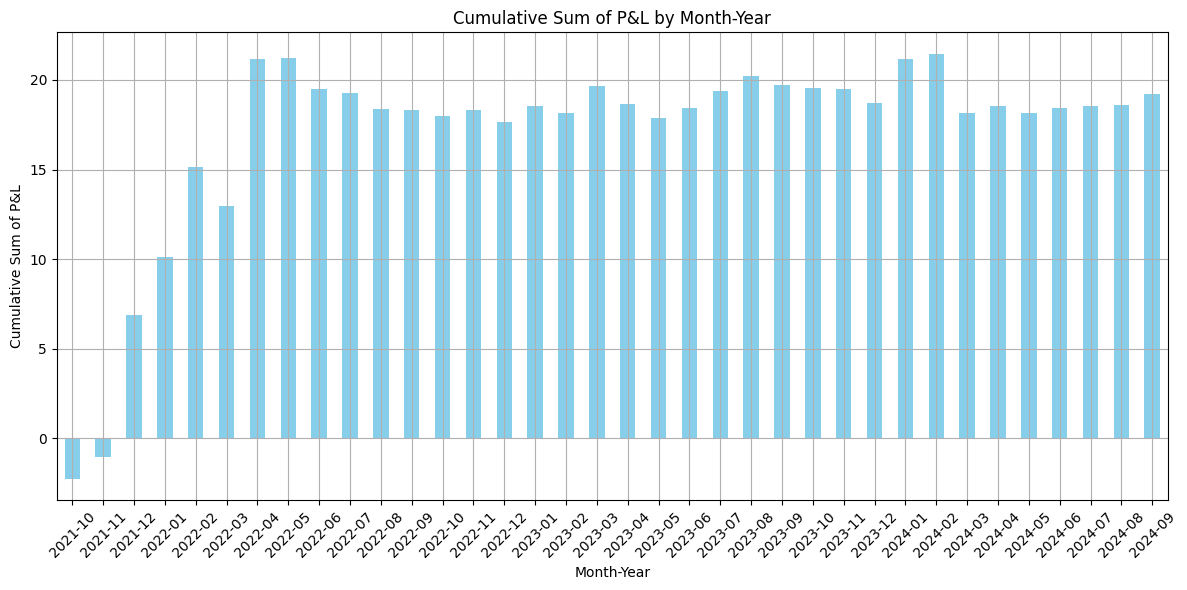

In [9]:
# Convert 'Time' column to datetime if it's not already
df_history_ordered['Time'] = pd.to_datetime(df_history_ordered['Time'])

# Extract month and year from 'Time' column
df_history_ordered['Month-Year'] = df_history_ordered['Time'].dt.to_period('M')

# Group by 'Month-Year' and calculate the cumulative sum of 'P&L'
monthly_cumulative_sum = df_history_ordered.groupby('Month-Year')['P&L'].sum().cumsum()

# Plot the bar graph
plt.figure(figsize=(12, 6))
monthly_cumulative_sum.plot(kind='bar', color='skyblue')
plt.title('Cumulative Sum of P&L by Month-Year')
plt.xlabel('Month-Year')
plt.ylabel('Cumulative Sum of P&L')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

La simulación denota un futuro en el que las ganancias progresivamente se desangraran (**Es urgente manejar las perdidas**) -> Siendo que la simualción fue hecha en un caso ideal

#### Grafica de Simulación-Profit por Ticker

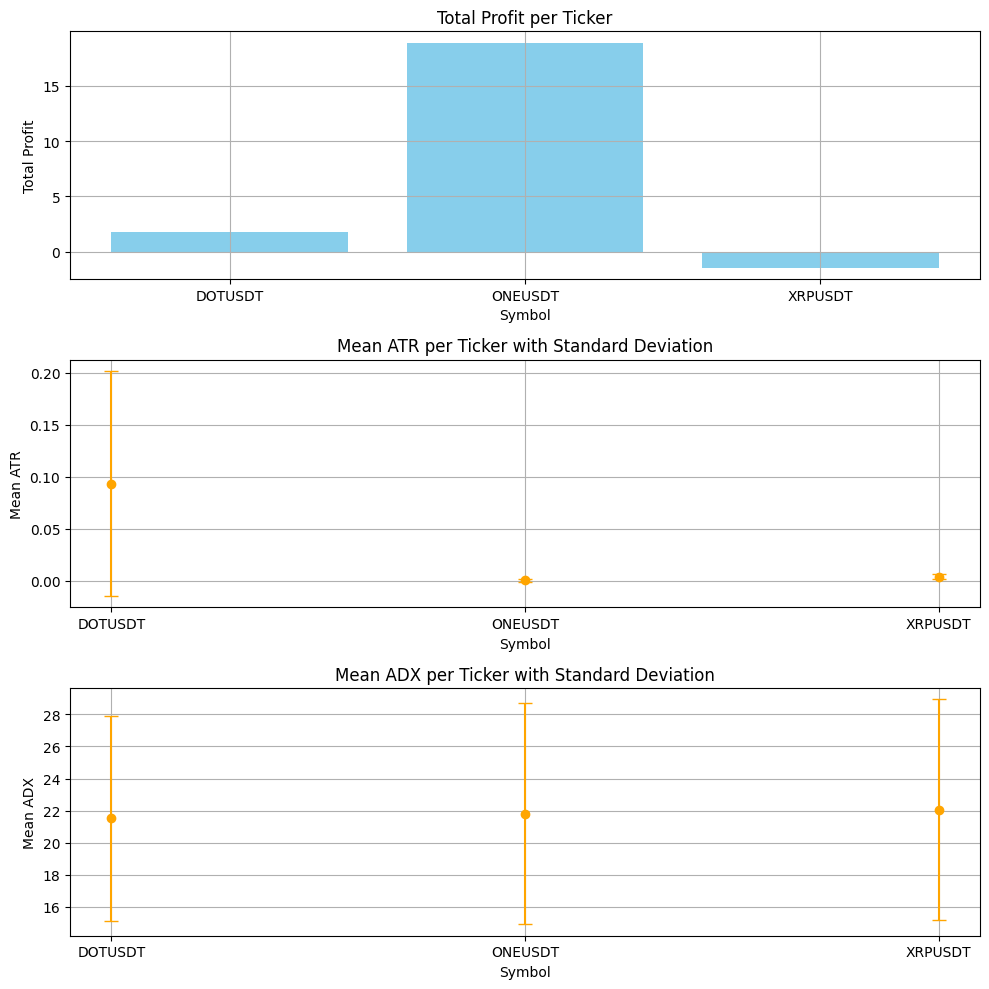

In [10]:
# Crear dataframe agrupado
grouped_df = df_history_ordered.groupby('Symbol').agg(
    total_profit=('P&L', 'sum'),
    mean_atr=('ATR', 'mean'),
    std_atr=('ATR', 'std'),
    mean_ADX = ('ADX', 'mean'),
    std_ADX = ('ADX', 'std'),
).reset_index()

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))  # Two rows, one column

# Plot 1: Bar chart for total profit
ax1.bar(grouped_df['Symbol'], grouped_df['total_profit'], color='skyblue')
ax1.set_xlabel('Symbol')
ax1.set_ylabel('Total Profit')
ax1.set_title('Total Profit per Ticker')
ax1.grid(True)

# Plot 2: Error bar plot for mean ATR with standard deviation
ax2.errorbar(grouped_df['Symbol'], grouped_df['mean_atr'], yerr=grouped_df['std_atr'],
            fmt='o', color='orange', capsize=5)
ax2.set_xlabel('Symbol')
ax2.set_ylabel('Mean ATR')
ax2.set_title('Mean ATR per Ticker with Standard Deviation')
ax2.grid(True)

# Plot 3: Error bar plot for mean ADX with standard deviation
ax3.errorbar(grouped_df['Symbol'], grouped_df['mean_ADX'], yerr=grouped_df['std_ADX'],
            fmt='o', color='orange', capsize=5)
ax3.set_xlabel('Symbol')
ax3.set_ylabel('Mean ADX')
ax3.set_title('Mean ADX per Ticker with Standard Deviation')
ax3.grid(True)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

#### Grafica por Ticker ATR y Profit-Simulado (Coloreado por Half-Price)


In [11]:
# Crear función de la grafica

def create_graph(ticker: str, df: pd.DataFrame):
        # Filter the DataFrame for the given ticker
        ticker_df = df[df['Symbol'] == ticker]
        
        # Map the 'Half-Price' boolean to colors (True = one color, False = another)
        colors = ticker_df['Half-Order'].map({True: 'green', False: 'red'})
        
        # Create scatter plot
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(ticker_df['ATR'], ticker_df['P&L'], c=colors, label=ticker_df['Half-Order'])
        
        # Add labels and title
        plt.xlabel('ATR')
        plt.ylabel('Simulation_Profit')
        plt.title(f'Scatter Plot of Profit vs ATR for {ticker}')
        
        # Create a legend to show the meaning of colors
        handles = [plt.Line2D([0], [0], marker='o', color='w', label='Half-Price: True', markerfacecolor='green', markersize=10),
                plt.Line2D([0], [0], marker='o', color='w', label='Half-Price: False', markerfacecolor='red', markersize=10)]
        plt.legend(handles=handles)
        
        # Show plot
        plt.grid(True)
        plt.show()

##### Ticker -> ONEUSDT

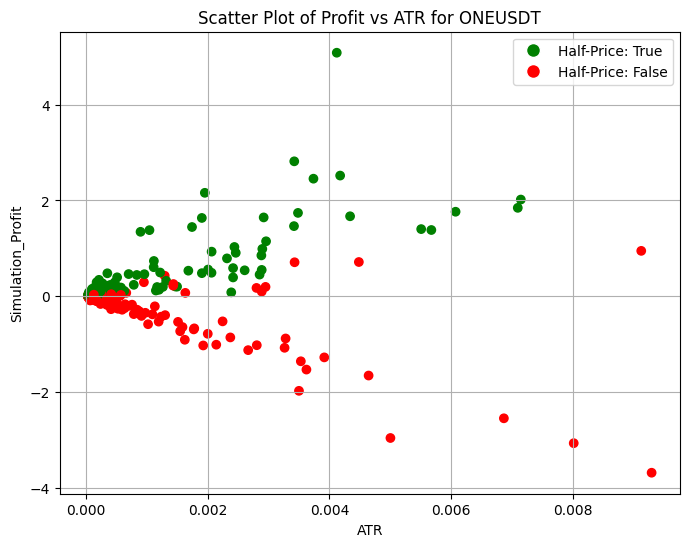

In [12]:
create_graph('ONEUSDT',df_history_ordered)

##### Ticker -> XRPUSDT

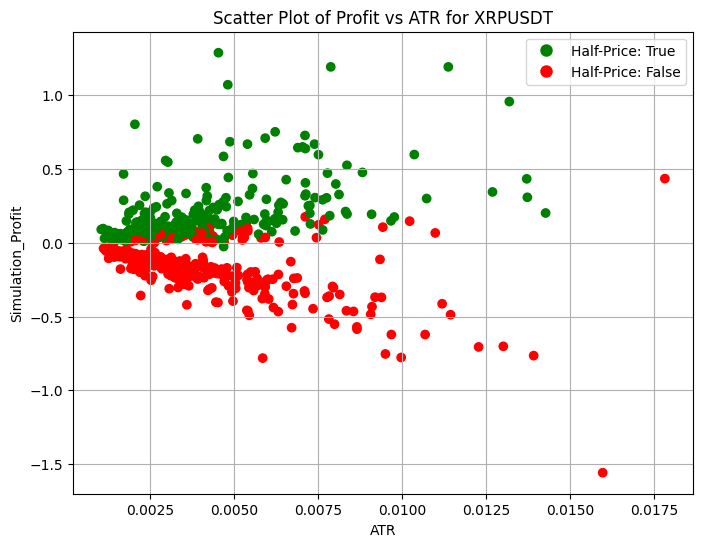

In [13]:
create_graph('XRPUSDT',df_history_ordered)

##### Ticker -> DOTUSDT

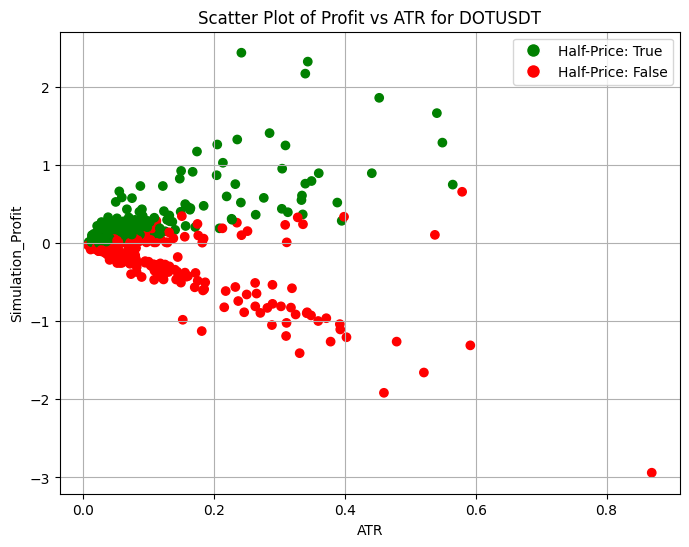

In [14]:
create_graph('DOTUSDT',df_history_ordered)

#### Grafica por Ticker ATR y Profit-Simulado (Coloreado por Half-Price)

In [15]:
def create_graph_adx(ticker: str, df: pd.DataFrame):
        # Filter the DataFrame for the given ticker
        ticker_df = df[df['Symbol'] == ticker]
        
        # Map the 'Half-Price' boolean to colors (True = one color, False = another)
        colors = ticker_df['Half-Order'].map({True: 'green', False: 'red'})
        
        # Create scatter plot
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(ticker_df['ADX'], ticker_df['P&L'], c=colors, label=ticker_df['Half-Order'])
        
        # Add labels and title
        plt.xlabel('ADX')
        plt.ylabel('Simulation_Profit')
        plt.title(f'Scatter Plot of Profit vs ADX for {ticker}')
        
        # Create a legend to show the meaning of colors
        handles = [plt.Line2D([0], [0], marker='o', color='w', label='Half-Price: True', markerfacecolor='green', markersize=10),
                plt.Line2D([0], [0], marker='o', color='w', label='Half-Price: False', markerfacecolor='red', markersize=10)]
        plt.legend(handles=handles)
        
        # Show plot
        plt.grid(True)
        plt.show()

##### Ticker -> ONEUSDT

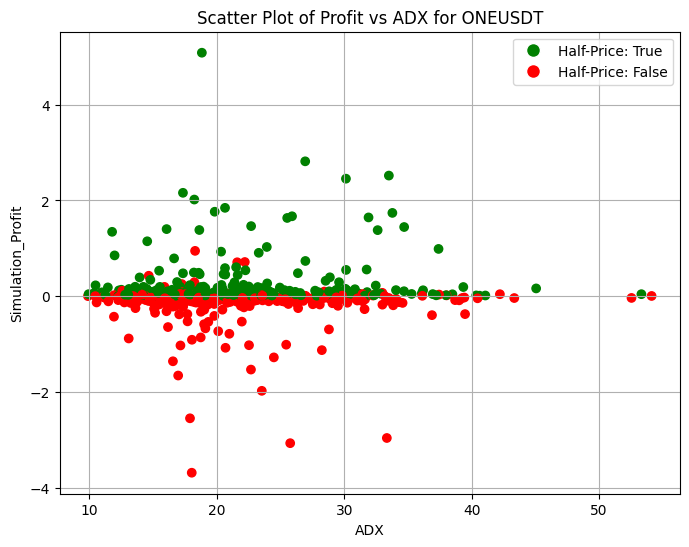

In [16]:
create_graph_adx('ONEUSDT',df_history_ordered)

##### Ticker -> XRPUSDT

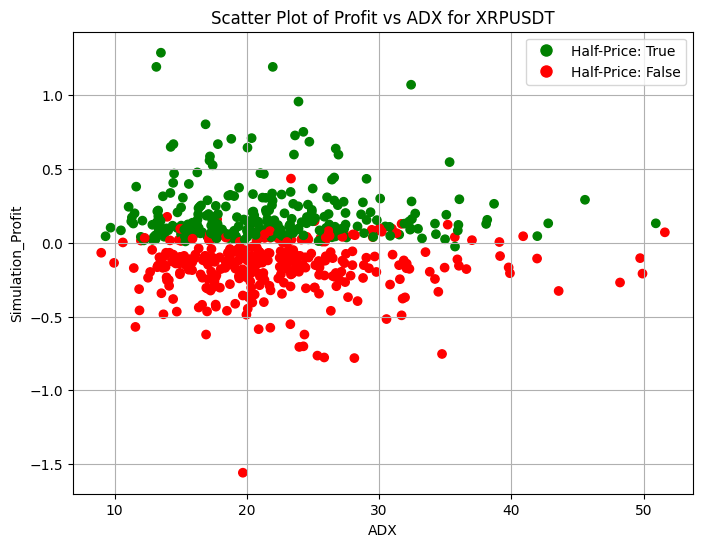

In [17]:
create_graph_adx('XRPUSDT',df_history_ordered)

##### Ticker -> DOTUSDT

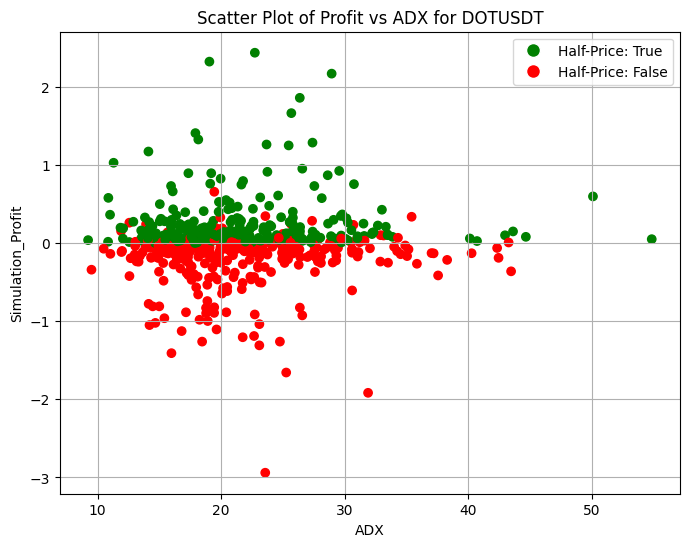

In [18]:
create_graph_adx('DOTUSDT',df_history_ordered)

## Crear Flujo de Transformaciónes

Se usaran estas transformaciones para entrenar un modelo de ML no supervisado, esto con el fin de ver las features mas importantes y revisar la viabilidad de construir modelos mas complejos basados en estos datos

In [19]:
df_history_ordered.head()

,Time,Symbol,Open,High,Low,Close,Volume,Supertrend,Polaridad,DEMA800,Half-Order,Profit,Stoploss-Reached,Exit-Price,ATR,ADX,P&L,Month-Year
0,2021-10-24 03:00:00-05:00,XRPUSDT,1.0848,1.0860,1.0831,1.0842,1473773.0,1.093251,Sell,1.130686,True,False,False,1.084200,0.003242,20.870454,0.0294,2021-10
1214,2021-10-24 06:30:00-05:00,DOTUSDT,43.3150,43.3450,42.4850,42.5950,103502.6,44.030335,Sell,45.024116,False,False,True,44.030335,0.330754,15.977562,-1.4080,2021-10
1215,2021-10-26 09:00:00-05:00,DOTUSDT,44.0950,44.1050,43.3050,43.6300,67713.6,44.732323,Sell,45.379222,False,False,True,44.732323,0.302189,14.459867,-0.8080,2021-10
1,2021-10-26 09:00:00-05:00,XRPUSDT,1.1121,1.1123,1.0950,1.1008,10803134.0,1.124411,Sell,1.123274,False,False,True,1.124411,0.006311,23.326970,-0.2142,2021-10
1216,2021-10-26 17:30:00-05:00,DOTUSDT,45.2050,45.2050,43.6450,44.3450,115117.2,46.551982,Sell,45.498452,True,True,False,42.470000,0.540539,25.676744,1.6680,2021-10


In [20]:
import pandas as pd

def clean_data(df_history_ordered):
    # Drop column: 'Month-Year'
    df_history_ordered = df_history_ordered.drop(columns=['Month-Year'])
    # One-hot encode columns: 'Symbol', 'Polaridad'
    for column in ['Symbol', 'Polaridad']:
        insert_loc = df_history_ordered.columns.get_loc(column)
        df_history_ordered = pd.concat([df_history_ordered.iloc[:,:insert_loc], pd.get_dummies(df_history_ordered.loc[:, [column]]), df_history_ordered.iloc[:,insert_loc+1:]], axis=1)
    # Scale columns 'Open', 'High' and 8 other columns between 0 and 1
    new_min, new_max = 0, 1
    old_min, old_max = df_history_ordered['Open'].min(), df_history_ordered['Open'].max()
    df_history_ordered['Open'] = (df_history_ordered['Open'] - old_min) / (old_max - old_min) * (new_max - new_min) + new_min
    old_min, old_max = df_history_ordered['High'].min(), df_history_ordered['High'].max()
    df_history_ordered['High'] = (df_history_ordered['High'] - old_min) / (old_max - old_min) * (new_max - new_min) + new_min
    old_min, old_max = df_history_ordered['Low'].min(), df_history_ordered['Low'].max()
    df_history_ordered['Low'] = (df_history_ordered['Low'] - old_min) / (old_max - old_min) * (new_max - new_min) + new_min
    old_min, old_max = df_history_ordered['Close'].min(), df_history_ordered['Close'].max()
    df_history_ordered['Close'] = (df_history_ordered['Close'] - old_min) / (old_max - old_min) * (new_max - new_min) + new_min
    old_min, old_max = df_history_ordered['Volume'].min(), df_history_ordered['Volume'].max()
    df_history_ordered['Volume'] = (df_history_ordered['Volume'] - old_min) / (old_max - old_min) * (new_max - new_min) + new_min
    old_min, old_max = df_history_ordered['Supertrend'].min(), df_history_ordered['Supertrend'].max()
    df_history_ordered['Supertrend'] = (df_history_ordered['Supertrend'] - old_min) / (old_max - old_min) * (new_max - new_min) + new_min
    old_min, old_max = df_history_ordered['DEMA800'].min(), df_history_ordered['DEMA800'].max()
    df_history_ordered['DEMA800'] = (df_history_ordered['DEMA800'] - old_min) / (old_max - old_min) * (new_max - new_min) + new_min
    old_min, old_max = df_history_ordered['Exit-Price'].min(), df_history_ordered['Exit-Price'].max()
    df_history_ordered['Exit-Price'] = (df_history_ordered['Exit-Price'] - old_min) / (old_max - old_min) * (new_max - new_min) + new_min
    old_min, old_max = df_history_ordered['ATR'].min(), df_history_ordered['ATR'].max()
    df_history_ordered['ATR'] = (df_history_ordered['ATR'] - old_min) / (old_max - old_min) * (new_max - new_min) + new_min
    old_min, old_max = df_history_ordered['ADX'].min(), df_history_ordered['ADX'].max()
    df_history_ordered['ADX'] = (df_history_ordered['ADX'] - old_min) / (old_max - old_min) * (new_max - new_min) + new_min
    return df_history_ordered

df_history_ordered_clean = clean_data(df_history_ordered.copy())
df_history_ordered_clean.head()

,Time,Symbol_DOTUSDT,Symbol_ONEUSDT,Symbol_XRPUSDT,Open,High,Low,Close,Volume,Supertrend,Polaridad_Buy,Polaridad_Sell,DEMA800,Half-Order,Profit,Stoploss-Reached,Exit-Price,ATR,ADX,P&L
0,2021-10-24 03:00:00-05:00,False,False,True,0.020452,0.020121,0.020603,0.020146,0.004309,0.020361,False,True,0.021078,True,False,False,0.020248,0.003693,0.259307,0.0294
1214,2021-10-24 06:30:00-05:00,True,False,False,0.823214,0.809550,0.814638,0.797850,0.000300,0.826610,False,True,0.845941,False,False,True,0.828902,0.380579,0.152603,-1.4080
1215,2021-10-26 09:00:00-05:00,True,False,False,0.838042,0.823747,0.830364,0.817240,0.000196,0.839792,False,True,0.852614,False,False,True,0.842120,0.347707,0.119505,-0.8080
1,2021-10-26 09:00:00-05:00,False,False,True,0.020971,0.020612,0.020831,0.020457,0.031598,0.020946,False,True,0.020938,False,False,True,0.021005,0.007224,0.312878,-0.2142
1216,2021-10-26 17:30:00-05:00,True,False,False,0.859142,0.844296,0.836885,0.830636,0.000334,0.873960,False,True,0.854855,True,True,False,0.799522,0.621990,0.364122,1.6680


## Crear Modelo No Spuervisado Random Forest

In [21]:
#Excluir columnas que no seran usadas para este analisis
columns_to_exclude = ["Time","Exit-Price", "P&L"]
df_history_ordered_drop_clean = df_history_ordered_clean.drop(columns=columns_to_exclude).copy()
df_history_ordered_drop_clean.head(5)

,Symbol_DOTUSDT,Symbol_ONEUSDT,Symbol_XRPUSDT,Open,High,Low,Close,Volume,Supertrend,Polaridad_Buy,Polaridad_Sell,DEMA800,Half-Order,Profit,Stoploss-Reached,ATR,ADX
0,False,False,True,0.020452,0.020121,0.020603,0.020146,0.004309,0.020361,False,True,0.021078,True,False,False,0.003693,0.259307
1214,True,False,False,0.823214,0.809550,0.814638,0.797850,0.000300,0.826610,False,True,0.845941,False,False,True,0.380579,0.152603
1215,True,False,False,0.838042,0.823747,0.830364,0.817240,0.000196,0.839792,False,True,0.852614,False,False,True,0.347707,0.119505
1,False,False,True,0.020971,0.020612,0.020831,0.020457,0.031598,0.020946,False,True,0.020938,False,False,True,0.007224,0.312878
1216,True,False,False,0.859142,0.844296,0.836885,0.830636,0.000334,0.873960,False,True,0.854855,True,True,False,0.621990,0.364122


### Split de data para entrenamiento

In [22]:
# Features y targets
X = df_history_ordered_drop_clean[['Symbol_DOTUSDT','Symbol_ONEUSDT','Symbol_XRPUSDT','Open','High',
                                    'Low','Close','Volume','Supertrend','Polaridad_Buy','Polaridad_Sell',
                                    'DEMA800','ATR', 'ADX']]
y = df_history_ordered_drop_clean[['Half-Order','Profit','Stoploss-Reached']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Entrenamiento de los modelos

In [23]:
# Dictionary to hold the trained models
models = {}
predictions = {}

# Train a Random Forest model for each target
for target in y.columns:
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train[target])
    models[target] = rf
    
    # Predict probabilities
    y_pred_prob = rf.predict_proba(X_test)[:, 1]  # Probability for the positive class
    
    # Store predictions
    predictions[target] = y_pred_prob

### Metricas de los modelos

In [24]:
for target in y.columns:
    y_pred = models[target].predict(X_test)
    print(f"Evaluation for {target}:")
    print("Accuracy:", accuracy_score(y_test[target], y_pred))
    print("Classification Report:\n", classification_report(y_test[target], y_pred))

Evaluation for Half-Order:
Accuracy: 0.49635036496350365
Classification Report:
               precision    recall  f1-score   support

       False       0.52      0.63      0.57       291
        True       0.45      0.35      0.39       257

    accuracy                           0.50       548
   macro avg       0.49      0.49      0.48       548
weighted avg       0.49      0.50      0.49       548

Evaluation for Profit:
Accuracy: 0.5164233576642335
Classification Report:
               precision    recall  f1-score   support

       False       0.55      0.70      0.62       308
        True       0.42      0.28      0.33       240

    accuracy                           0.52       548
   macro avg       0.49      0.49      0.48       548
weighted avg       0.50      0.52      0.49       548

Evaluation for Stoploss-Reached:
Accuracy: 0.5127737226277372
Classification Report:
               precision    recall  f1-score   support

       False       0.56      0.61      0.59     

### Exploración de Importancias

In [25]:
# Dictionary to store feature importances for each tree in each model
feature_importances_per_tree = {}

for target in models:
    rf = models[target]
    # Access the feature importances of each tree
    importances = np.array([tree.feature_importances_ for tree in rf.estimators_])
    feature_importances_per_tree[target] = importances

#Crear un reporte con la media de importancia
for target in feature_importances_per_tree:
    importances = feature_importances_per_tree[target]
    mean_importances = importances.mean(axis=0)
    print("---------------------------------------------------------------------------------")
    print(f"Mean feature importances for {target}:")
    for feature, importance in zip(X.columns, mean_importances):
        print(f"{feature}: {importance}")
    print("---------------------------------------------------------------------------------")

---------------------------------------------------------------------------------
Mean feature importances for Half-Order:
Symbol_DOTUSDT: 0.00025470975762807295
Symbol_ONEUSDT: 0.0009786516543000836
Symbol_XRPUSDT: 0.0013411412636167655
Open: 0.09341221207730344
High: 0.09770200474192549
Low: 0.09713910990040663
Close: 0.09554698889938854
Volume: 0.1291229643133903
Supertrend: 0.09810891127866359
Polaridad_Buy: 0.010011233727030076
Polaridad_Sell: 0.010428748416211317
DEMA800: 0.11132622543252102
ATR: 0.11898804292306682
ADX: 0.13563905561454795
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Mean feature importances for Profit:
Symbol_DOTUSDT: 0.0007135808052124656
Symbol_ONEUSDT: 0.0012386511657422742
Symbol_XRPUSDT: 0.0017769661206113471
Open: 0.09359495824258056
High: 0.09558299776315637
Low: 0.09204930943692469
Close: 0.095250613334919
Volume: 0.12718376852002844
Su